In [1]:
from google.colab import drive
import os
import shutil
import random

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Training

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
class BreakfastDataset(Dataset):
    def __init__(self, root_dir, class_map, transform=None, num_frames=128):
        self.root_dir = root_dir
        self.transform = transform
        self.video_files = []
        self.labels = []
        self.class_map = class_map
        self.num_frames = num_frames

        for person_folder in os.listdir(root_dir):
            person_path = os.path.join(root_dir, person_folder)
            if os.path.isdir(person_path):
                for video_name in os.listdir(person_path):
                    class_name = video_name.split('_')[1].split('.')[0]
                    if class_name not in self.class_map:
                        self.class_map[class_name] = len(self.class_map)
                    self.video_files.append(os.path.join(person_path, video_name))
                    self.labels.append(self.class_map[class_name])

        print(f"labels = {self.labels} , \n labels_len = {len(self.labels)}")
        print(f"video_files = {self.video_files} , \n video_files_len = {len(self.video_files)}")
        print(f" \n class_map = {self.class_map}")
        print(f"_______________________ end of constructor __________________________")

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        frames = self.load_video(video_path)
        label = self.labels[idx]

        if self.transform:
            frames = [self.transform(frame) for frame in frames]
            frames = torch.stack(frames)

        if frames.shape[0] < self.num_frames:
            pad_size = self.num_frames - frames.shape[0]
            padding = torch.zeros(pad_size, frames.shape[1], frames.shape[2], frames.shape[3])
            frames = torch.cat((frames, padding), dim=0)
        elif frames.shape[0] > self.num_frames:
            frames = frames[:self.num_frames]

        return frames, label

    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        frames = np.array(frames)
        return frames

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

class CustomR3D(nn.Module):
    def __init__(self, num_classes):
        super(CustomR3D, self).__init__()
        self.model = r3d_18(weights='KINETICS400_V1')
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = [total_samples / class_count for class_count in class_counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    return class_weights

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience=5):
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.permute(0, 2, 1, 3, 4).float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print("Early stopping triggered")
                    model.load_state_dict(torch.load('best_model.pth'))
                    return model

    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [ ]:
data_dir = '/content/drive/My Drive/Breakfast_Action_Recognition'
batch_size = 16
num_epochs = 25

class_map = {}

image_datasets = {x: BreakfastDataset(os.path.join(data_dir, x), class_map, transform) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=10) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
all_labels = image_datasets['train'].labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CustomR3D(num_classes=len(image_datasets['train'].class_map))
model = model.to(device)

class_weights = calculate_class_weights(all_labels)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=num_epochs, patience=5)

torch.save(model.state_dict(), '/content/drive/My Drive/breakfast_action_recognition_model_2.pth')


labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 4, 5, 0, 2, 7, 1, 3, 8, 9, 5, 4, 9, 3, 7, 1, 2, 8, 9, 4, 6, 5, 0, 5, 0, 4, 7, 2, 9, 3, 8, 1, 2, 3, 6, 1, 5, 9, 0, 7, 4, 8, 2, 4, 6, 5, 0, 8, 1, 9, 7, 3, 9, 3, 8, 5, 1, 0, 7, 2, 6, 4, 6, 5, 3, 9, 7, 1, 4, 2, 2, 6, 8, 7, 1, 0, 4, 5, 3, 9, 9, 1, 8, 2, 7, 3, 5, 6, 0, 4, 2, 6, 7, 1, 5, 8, 3, 4, 9, 0, 2, 5, 6, 9, 1, 4, 7, 0, 3, 8, 3, 5, 4, 2, 8, 9, 7, 1, 1, 4, 3, 6, 2, 5, 9, 8, 7, 2, 0, 5, 7, 4, 6, 9, 8, 0, 5, 8, 3, 1, 9, 6, 0, 8, 1, 4, 2, 3, 9, 6, 5, 7, 0, 2, 8, 5, 3, 1, 6, 7, 7, 1, 6, 2, 9, 4, 0, 7, 8, 6, 1, 2, 5, 3, 5, 6, 1, 2, 0, 9, 7, 3, 2, 1, 9, 6, 7, 0, 4, 5, 8, 2, 4, 6, 0, 9, 5, 1, 3, 8, 7, 3, 5, 2, 4, 6, 0, 7, 1, 8, 9, 4, 8, 6, 1, 9, 3, 0, 5, 2, 7, 2, 4, 5, 6, 8, 1, 7, 3, 4, 6, 2, 0, 5, 7, 1, 9, 3, 8, 1, 2, 7, 5, 8, 6, 3, 4, 0, 2, 1, 6, 8, 3, 0, 4, 9, 5, 7, 2, 0, 7, 4, 5, 8, 6, 9, 3, 4, 2, 0, 3, 1, 5, 7, 6, 8, 2, 4, 5, 0, 6, 3, 7, 9, 1, 8, 4, 2, 0, 6, 7, 5, 1, 9, 8, 2, 4, 0, 9, 5, 1, 8, 3, 7, 5, 4, 0, 3, 9, 2, 7, 8, 1, 2, 1, 5, 8, 7, 0, 4, 

### Model Inference

In [12]:
class_map = {'coffee': 0, 'salat': 1, 'cereals': 2, 'pancake': 3, 'friedegg': 4, 'milk': 5, 'juice': 6, 'sandwich': 7, 'tea': 8, 'scrambledegg': 9}

def load_model(model_path, num_classes):
    model = CustomR3D(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to prepare the input video and perform inference
def predict(model, video_path, transform, num_frames=128):
    frames = load_video(video_path)
    if len(frames) == 0:
        raise ValueError(f"No frames found in video {video_path}")

    if transform:
        frames = [transform(frame) for frame in frames]
        frames = torch.stack(frames)

    if frames.shape[0] < num_frames:
        pad_size = num_frames - frames.shape[0]
        padding = torch.zeros(pad_size, frames.shape[1], frames.shape[2], frames.shape[3])
        frames = torch.cat((frames, padding), dim=0)
    elif frames.shape[0] > num_frames:
        frames = frames[:num_frames]

    frames = frames.unsqueeze(0)  # Add batch dimension
    frames = frames.permute(0, 2, 1, 3, 4).float()  # Reshape to [batch, channels, depth, height, width]

    with torch.no_grad():
        outputs = model(frames)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# Function to load the video for inference
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.array(frames)
    print(f"Loaded {len(frames)} frames from {video_path}")
    return frames

# Load the model
model_path = '/content/drive/My Drive/breakfast_action_recognition_model_2.pth'
num_classes = len(class_map)  # Set the number of classes based on your dataset
model_y = load_model(model_path, num_classes)

# Define the video path for inference
video_path = '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P50/P50_friedegg.avi'

# Perform inference
predicted_class = predict(model_y, video_path, transform)

idx_to_class = {v: k for k, v in class_map.items()}
predicted_class_name = idx_to_class[predicted_class]

print(f'Predicted class: {predicted_class_name}')

Loaded 1599 frames from /content/drive/My Drive/Breakfast_Action_Recognition/valid/P50/P50_friedegg.avi
Predicted class: friedegg


### Confusion Matrix

labels = [9, 6, 10, 0, 11, 2, 4, 1, 3, 7, 8, 5, 6, 5, 3, 4, 2, 0, 1, 7, 8, 9, 1, 5, 9, 2, 6, 3, 7, 8, 4, 3, 5, 6, 2, 4, 9, 1, 11, 7, 8] , 
 labels_len = 41
video_files = ['/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_scrambledegg.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_juice.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_milk (1).avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_coffee.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_tea (1).avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_cereals.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_friedegg.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_salat.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_pancake.avi', '/content/drive/My Drive/Breakfast_Action_Recognition/valid/P49/P49_sandwich.avi', '/cont

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bc8e0d0a170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


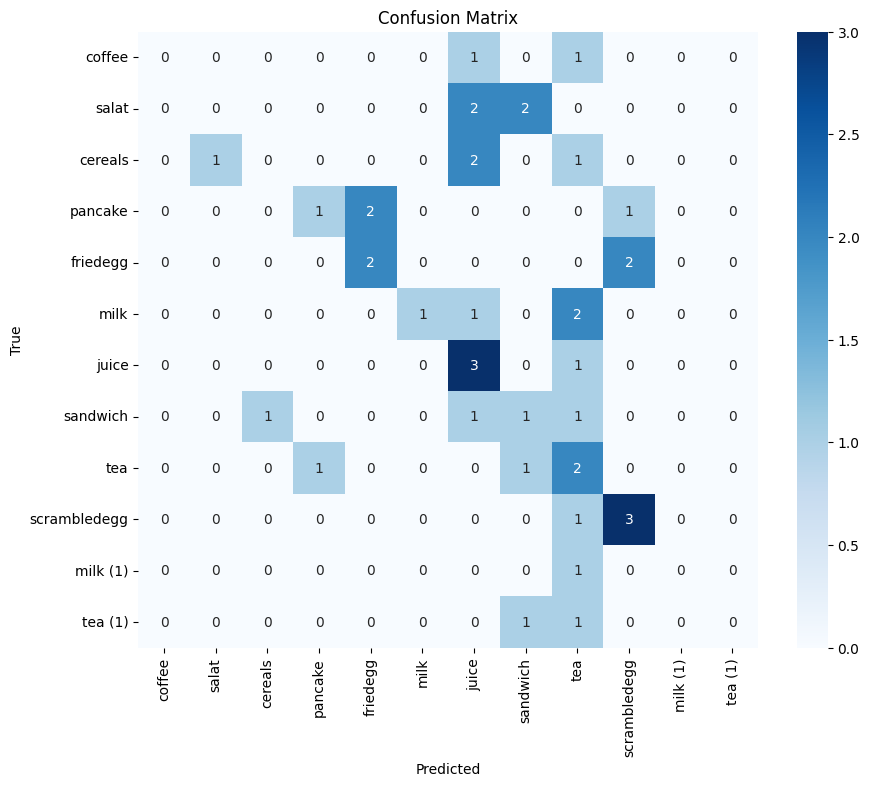

In [15]:
# Prepare the dataset and dataloaders
data_dir = '/content/drive/My Drive/Breakfast_Action_Recognition'
batch_size = 1

image_datasets = {x: BreakfastDataset(os.path.join(data_dir, x), class_map, transform) for x in ['valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) for x in ['valid']}

# Get the validation set
valid_loader = dataloaders['valid']

# Perform inference on the validation set and get predictions
all_preds = []
all_labels = []

for inputs, labels in valid_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.permute(0, 2, 1, 3, 4).float()  # Reshape to [batch, channels, depth, height, width]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_map.keys()), yticklabels=list(class_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Validation Accuracy

In [16]:
validation_accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {validation_accuracy:.4f}')


Validation Accuracy: 0.3171
